## Recommender Systems (Movie/Web Show Recommendation)

### Step 1: Retrieving the Data

In [1]:
#!pip install scikit-surprise
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.knns import KNNBasic
from collections import defaultdict

In [2]:
# Read the data
movie_data = pd.read_csv('IMDB-Dataset/movies.csv')
rating_data = pd.read_csv('IMDB-Dataset/ratings.csv')

# Display structure and summary
print(movie_data.info())
print(movie_data.describe())
print(movie_data.head())

print(rating_data.describe())
print(rating_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None
             movieId
count   10329.000000
mean    31924.282893
std     37734.741149
min         1.000000
25%      3240.000000
50%      7088.000000
75%     59900.000000
max    149532.000000
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2            

### Step 2: Data Pre-processing

In [3]:
# One-hot encoding for genres
genres = movie_data['genres'].str.get_dummies('|')
print(genres.head())

# Check structure of the new genre matrix
print(genres.info())

# Create a search matrix
search_matrix = pd.concat([movie_data[['movieId', 'title']], genres], axis=1)
print(search_matrix.head())

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  \
0            0      0        1          0       0     0        0        0   
1            0      0        1          0       0     0        0        0   
2            0      0        0          0       0     0        0        0   
3            0      1        0          0       0     0        0        0   
4            0      0        0          0       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0 

### Step 3: Creating Rating Matrix

In [4]:
# Pivot rating data to create matrix
rating_matrix = rating_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert to sparse matrix
rating_matrix_sparse = csr_matrix(rating_matrix.values)
print(rating_matrix_sparse)

  (0, 15)	4.0
  (0, 23)	1.5
  (0, 31)	4.0
  (0, 44)	4.0
  (0, 47)	4.0
  (0, 98)	4.0
  (0, 126)	3.0
  (0, 137)	4.0
  (0, 141)	3.0
  (0, 176)	0.5
  (0, 194)	4.0
  (0, 226)	0.5
  (0, 230)	4.5
  (0, 231)	1.5
  (0, 246)	0.5
  (0, 260)	4.0
  (0, 279)	4.0
  (0, 309)	4.5
  (0, 316)	3.0
  (0, 336)	2.5
  (0, 339)	3.0
  (0, 405)	4.0
  (0, 426)	3.5
  (0, 471)	4.5
  (0, 522)	3.5
  :	:
  (667, 10228)	3.5
  (667, 10230)	3.5
  (667, 10231)	2.0
  (667, 10232)	2.5
  (667, 10233)	3.5
  (667, 10234)	3.0
  (667, 10240)	3.0
  (667, 10245)	2.5
  (667, 10247)	4.0
  (667, 10248)	3.5
  (667, 10252)	3.0
  (667, 10254)	3.0
  (667, 10263)	4.0
  (667, 10271)	4.0
  (667, 10276)	2.0
  (667, 10277)	2.5
  (667, 10283)	4.0
  (667, 10286)	2.5
  (667, 10295)	2.5
  (667, 10299)	2.5
  (667, 10303)	4.0
  (667, 10304)	3.5
  (667, 10312)	4.0
  (667, 10317)	2.5
  (667, 10323)	4.5


### Step 4: Exploring Similar Data

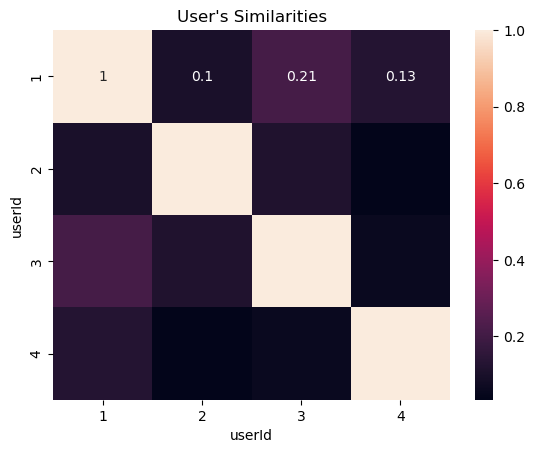

In [5]:
# Compute user similarities
user_similarities = cosine_similarity(rating_matrix_sparse)
user_similarities = pd.DataFrame(user_similarities, index=rating_matrix.index, columns=rating_matrix.index)

# Visualize user similarities
sns.heatmap(user_similarities.iloc[:4, :4], annot=True)
plt.title("User's Similarities")
plt.show()

### Step 5: Most Viewed Movies Visualization

     movieId  views                                      title
260      296    325                        Pulp Fiction (1994)
316      356    311                        Forrest Gump (1994)
279      318    308           Shawshank Redemption, The (1994)
426      480    294                       Jurassic Park (1993)
525      593    290           Silence of the Lambs, The (1991)
230      260    273  Star Wars: Episode IV - A New Hope (1977)


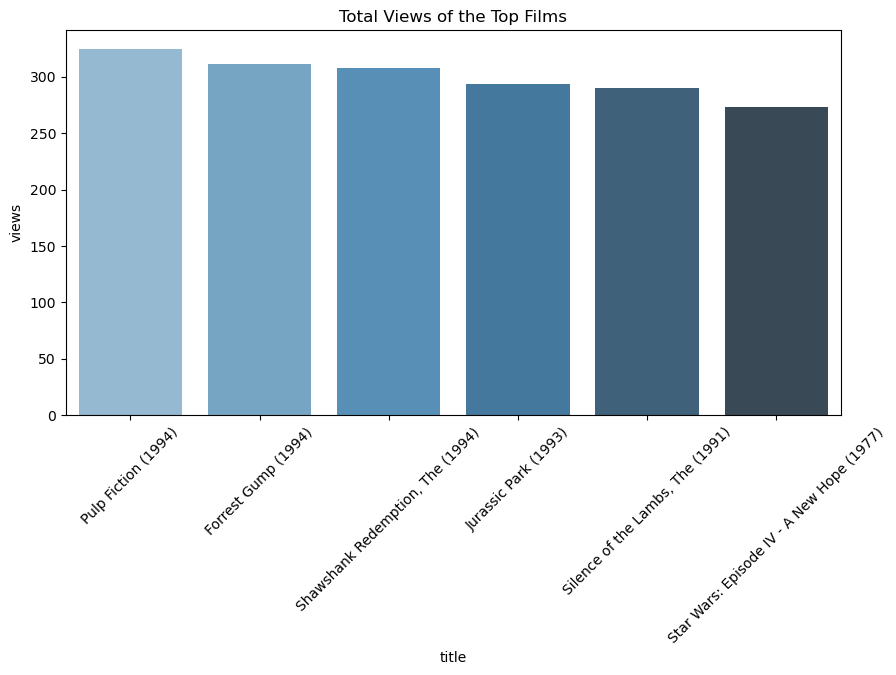

In [6]:
# Count movie views
movie_views = rating_matrix.astype(bool).sum(axis=0)
table_views = movie_views.reset_index().rename(columns={0: 'views'})
table_views = table_views.sort_values(by='views', ascending=False)

# Add movie titles
table_views['title'] = table_views['movieId'].apply(lambda x: movie_data.loc[movie_data['movieId'] == x, 'title'].values[0])

print(table_views.head(6))

# Plotting the most viewed movies
top_movies = table_views.head(6)
plt.figure(figsize=(10, 5))
sns.barplot(x='title', y='views', data=top_movies, palette='Blues_d')
plt.xticks(rotation=45)
plt.title('Total Views of the Top Films')
plt.show()

### Step 6: Building the Recommendation System

In [7]:
# Load data into surprise format
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(rating_data[['userId', 'movieId', 'rating']], reader)

# Split data into training and test set
trainset, testset = train_test_split(data, test_size=0.2)

# Train the model using Item-based Collaborative Filtering
algo = KNNBasic(sim_options={'user_based': False})
algo.fit(trainset)

# Make predictions
predictions = algo.test(testset)
accuracy.rmse(predictions)

# Get top recommendations for a user
def get_top_n_recommendations(predictions, n=10):
    # First map the predictions to each user.
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
    
    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

# Get top 10 recommendations for all users
top_n = get_top_n_recommendations(predictions, n=10)

# Display recommendations for the first user in the dataset
first_user = list(top_n.keys())[0]
print(f"Top 10 recommendations for user {first_user}:")
for movie_id, estimated_rating in top_n[first_user]:
    print(f"MovieID: {movie_id}, Estimated Rating: {estimated_rating}")


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9190
Top 10 recommendations for user 668:
MovieID: 4432, Estimated Rating: 3.75
MovieID: 7218, Estimated Rating: 3.6625
MovieID: 668, Estimated Rating: 3.6125
MovieID: 40414, Estimated Rating: 3.6010638297872344
MovieID: 7070, Estimated Rating: 3.5875
MovieID: 8712, Estimated Rating: 3.5618279569892475
MovieID: 7211, Estimated Rating: 3.5618279569892475
MovieID: 37113, Estimated Rating: 3.518001447710363
MovieID: 105211, Estimated Rating: 3.518001447710363
MovieID: 95613, Estimated Rating: 3.518001447710363


### Map Movie IDs to Movie Titles:
You will likely want to map the movie IDs back to their titles to make the recommendations more understandable.

In [8]:
# Create a mapping of movieId to movieTitle
id_to_title = pd.Series(movie_data.title.values, index=movie_data.movieId).to_dict()

# Display recommendations with movie titles for the first user
print(f"Top 10 recommendations for user {first_user}:")
for movie_id, estimated_rating in top_n[first_user]:
    print(f"MovieID: {movie_id}, Title: {id_to_title[movie_id]}, Estimated Rating: {estimated_rating}")


Top 10 recommendations for user 668:
MovieID: 4432, Title: Sweet Smell of Success (1957), Estimated Rating: 3.75
MovieID: 7218, Title: Ox-Bow Incident, The (1943), Estimated Rating: 3.6625
MovieID: 668, Title: Song of the Little Road (Pather Panchali) (1955), Estimated Rating: 3.6125
MovieID: 40414, Title: Joyeux Noël (Merry Christmas) (2005), Estimated Rating: 3.6010638297872344
MovieID: 7070, Title: Red River (1948), Estimated Rating: 3.5875
MovieID: 8712, Title: My Favorite Wife (1940), Estimated Rating: 3.5618279569892475
MovieID: 7211, Title: People Will Talk (1951), Estimated Rating: 3.5618279569892475
MovieID: 37113, Title: Golden Boy (1939), Estimated Rating: 3.518001447710363
MovieID: 105211, Title: Enough Said (2013), Estimated Rating: 3.518001447710363
MovieID: 95613, Title: Union, The (2011), Estimated Rating: 3.518001447710363


### Evaluate Other Metrics (Optional):
Besides RMSE, you might want to evaluate your model using other metrics like Precision, Recall, or F1-score.

In [9]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = {}
    recalls = {}
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    # Average precision and recall
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    
    return avg_precision, avg_recall

# Calculate precision and recall at k
precision, recall = precision_recall_at_k(predictions, k=10, threshold=3.5)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')


Precision: 0.7739, Recall: 0.5354
